In [61]:
# Install required packages
%pip install matplotlib numpy pandas torch


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
import warnings
warnings.filterwarnings("ignore")

In [63]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Graph Convolutional Auto-Encoder

In [ ]:
# Laplace normalization
class LplsNorm(nn.Module):
    def __init__(self):
        super(LplsNorm, self).__init__()

    def forward(self, adjacency_matrix):
        degree = torch.sum(adjacency_matrix, dim=-1)
        diag = torch.diag(torch.pow(degree, -0.5))
        out = diag.mm(adjacency_matrix).mm(diag)
        return out

# convolutional
class Convolution(nn.Module):
    def __init__(self, in_dimension, out_dimension):
        super(Convolution, self).__init__()
        self.LinearLayer = nn.Sequential(
            nn.Linear(in_dimension, out_dimension),
            nn.ReLU()
        )

    def forward(self, adjacency_matrix, feature):
        mf = feature + torch.mm(adjacency_matrix, feature)
        out = self.LinearLayer(mf)
        return out

class ConvolutionLayer(nn.Module):
    def __init__(self, in_dimension, embedding_dimension):
        super(ConvolutionLayer, self).__init__()
        self.LplsNorm = LplsNorm()

        self.Convolution = Convolution(in_dimension, embedding_dimension)

    def forward(self, adjacency_matrix, feature):
        adjacency_matrix = self.LplsNorm(adjacency_matrix)
        out = self.Convolution(adjacency_matrix, feature)
        return out

class GraphConvolution(nn.Module):
    # in_dimenssion: input_dimenssion
    def __init__(self, in_dimension, embedding_dimension):
        super(GraphConvolution, self).__init__()
        self.ConvolutionLayer = ConvolutionLayer(in_dimension, embedding_dimension)
        
        self.LinearLayer = nn.Sequential(
            nn.Linear(embedding_dimension, in_dimension),
            nn.ReLU(),
            nn.Linear(in_dimension, in_dimension)
        )

    def forward(self, matrix, feature):
        re = self.ConvolutionLayer(matrix, feature)
        rd = self.LinearLayer(re)
        
        return rd, re

In [65]:
class VGAE(nn.Module):
    def __init__(self, in_dimension, embedding_dimension):
        super(VGAE, self).__init__()
        self.LplsNorm = LplsNorm()

        # ----- ENCODER -----
        # Encoder bây giờ có 2 đầu ra: một cho mean và một cho log_var
        # Lớp Convolution này sẽ là lớp nền dùng chung
        shared_conv_layer = Convolution(in_dimension, embedding_dimension)
        
        # Tách thành hai lớp riêng biệt để học mu và log_var
        self.encoder_mu = shared_conv_layer
        self.encoder_log_var = Convolution(in_dimension, embedding_dimension) # Một lớp tương tự

        # ----- DECODER -----
        # Decoder giữ nguyên cấu trúc, nhận vector tiềm ẩn và tái tạo lại
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dimension, in_dimension),
            nn.ReLU(),
            nn.Linear(in_dimension, in_dimension)
        )

    def reparameterize(self, mu, log_var):
        """
        Đây là Reparameterization Trick.
        z = mu + epsilon * sigma
        Giúp cho quá trình lan truyền ngược (backpropagation) có thể diễn ra
        qua một bước lấy mẫu ngẫu nhiên.
        """
        if self.training:
            std = torch.exp(0.5 * log_var)  # sigma = exp(log(sigma^2) / 2)
            eps = torch.randn_like(std)    # epsilon ~ N(0, 1)
            return eps.mul(std).add_(mu)
        else:
            # Khi kiểm thử hoặc dự đoán, chúng ta không cần sự ngẫu nhiên
            # mà chỉ dùng mean để kết quả ổn định.
            return mu

    def forward(self, adjacency_matrix, feature):
        # Chuẩn hóa ma trận kề
        adj_norm = self.LplsNorm(adjacency_matrix)

        # 1. Quá trình ENCODE
        mu = self.encoder_mu(adj_norm, feature)
        log_var = self.encoder_log_var(adj_norm, feature)

        # 2. Lấy mẫu từ không gian tiềm ẩn (Reparameterization Trick)
        z = self.reparameterize(mu, log_var)

        # 3. Quá trình DECODE
        reconstructed_feature = self.decoder(z)
        
        # Trả về cả kết quả tái tạo, mu và log_var để tính loss
        return reconstructed_feature, mu, log_var

In [66]:
def vgae_loss_function(reconstructed_feature, original_feature, mu, log_var):
    """
    Hàm loss cho VGAE.
    Loss = Reconstruction Loss + KL Divergence Loss
    """
    # 1. Reconstruction Loss (ví dụ: Mean Squared Error)
    recon_loss = F.mse_loss(reconstructed_feature, original_feature, reduction='sum')

    # 2. KL Divergence Loss
    # Công thức: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kld_loss

preset parameter

In [67]:
dataset = "dataset2"
lnc_mi = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_mi.csv', index_col='0').values
mi_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/mi_di.csv', index_col='0').values
lnc_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_di.csv', index_col='0').values
L_num = lnc_mi.shape[0]
D_num = mi_di.shape[1]
M_num = mi_di.shape[0]
print(f"{L_num} --- {D_num} --- {M_num}")

665 --- 316 --- 295


In [68]:
A = np.load('./our_dataset/' + dataset + '/A/A_1_1.npy')
folds = 5
in_dimension = A.shape[1]
embedding_dimension = 128
learn_rate = 1e-3
weight_decay = 1e-5
n_epochs = 100
network_num = 4

train

In [69]:
# Giả định rằng bạn đã định nghĩa class VGAE và hàm vgae_loss_function ở trên
# from your_model_file import VGAE, vgae_loss_function

print("Start training VGAE") # <--- (Tùy chọn) Thay đổi tên cho rõ ràng
rds = []
res = [] # <--- List này sẽ lưu trữ 'mu' thay vì 're'
for fold in range(folds):
    d = []
    e = []
    for i in range(network_num):
        epoch = 0
        A = torch.Tensor(np.load('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1) + '.npy'))
        
        # Thay đổi 1: Sử dụng mô hình VGAE thay vì GraphConvolution
        model = VGAE(in_dimension, embedding_dimension) # <--- THAY ĐỔI
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
        
        # Thay đổi 2: Không cần định nghĩa MSELoss nữa vì đã có hàm loss riêng
        # loss_function = nn.MSELoss(reduction='mean') # <--- XÓA DÒNG NÀY

        while epoch < n_epochs:
            model.train()
            optimizer.zero_grad()
            
            # Thay đổi 3: Forward pass bây giờ trả về 3 giá trị
            reconstructed_A, mu, log_var = model(A, A) # <--- THAY ĐỔI
            
            # Thay đổi 4: Sử dụng hàm loss của VGAE
            loss = vgae_loss_function(reconstructed_A, A, mu, log_var) # <--- THAY ĐỔI
            
            loss.backward()
            optimizer.step()
            epoch += 1
            
        model.eval()
        with torch.no_grad():
            # Forward pass khi eval cũng trả về 3 giá trị
            rd, mu, log_var = model(A, A) # <--- THAY ĐỔI
            d.append(rd)
            
            # Thay đổi 5: Lưu 'mu' làm vector biểu diễn tiềm ẩn
            e.append(mu) # <--- THAY ĐỔI (thay 're' bằng 'mu')
            
        # Tên biến loss đã được cập nhật ở trên
        print(f"The layer {fold + 1} variational graph auto-encoder loss is {loss.detach().cpu().item()}")
    
    res.append(e)
    rds.append(d)

Start training VGAE
The layer 1 variational graph auto-encoder loss is 41091.21484375
The layer 1 variational graph auto-encoder loss is 46322.578125
The layer 1 variational graph auto-encoder loss is 46513.34375
The layer 1 variational graph auto-encoder loss is 46993.84765625
The layer 2 variational graph auto-encoder loss is 42035.26953125
The layer 2 variational graph auto-encoder loss is 46915.984375
The layer 2 variational graph auto-encoder loss is 47449.29296875
The layer 2 variational graph auto-encoder loss is 46647.94140625
The layer 3 variational graph auto-encoder loss is 41425.44921875
The layer 3 variational graph auto-encoder loss is 51055.265625
The layer 3 variational graph auto-encoder loss is 50894.88671875
The layer 3 variational graph auto-encoder loss is 52047.00390625
The layer 4 variational graph auto-encoder loss is 41864.75390625
The layer 4 variational graph auto-encoder loss is 47006.109375
The layer 4 variational graph auto-encoder loss is 48593.43359375
T

In [ ]:
# print("Start training")
# rds = []
# res = []
# for fold in range(folds):
#     d = []
#     e = []
#     for i in range(network_num):
#         epoch = 0
#         A = torch.Tensor(np.load('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1) + '.npy'))
        # model = GraphConvolution(in_dimension, embedding_dimension)
        # optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
        # loss_function = nn.MSELoss(reduction='mean')
#         while epoch < n_epochs:
#             model.train()
#             optimizer.zero_grad()
#             rd, re = model(A, A)
#             loss = loss_function(rd, A)
#             loss.backward()
#             optimizer.step()
#             epoch += 1
#         model.eval()
#         with torch.no_grad():
#             rd, re = model(A, A)
#             d.append(rd)
#             e.append(re)
#         print(f"The layer {fold + 1} graph convolutional auto-encoder loss is {loss.detach().cpu().item()}")
#     res.append(e)
#     rds.append(d)

Save the results

Saving file to: ./our_dataset/dataset2/A_new_encoder/A_1_1.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_1_2.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_1_3.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_1_4.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_2_1.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_2_2.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_2_3.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_2_4.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_3_1.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_3_2.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_3_3.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_3_4.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_4_1.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_4_2.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_4_3.npy
Saving file to: ./our_dataset/dataset2/A_new_encoder/A_

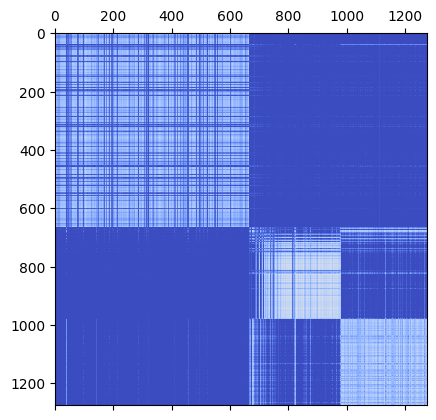

In [71]:
import os

output_dir = './our_dataset/' + dataset + '/A_new_encoder'
os.makedirs(output_dir, exist_ok=True)

for fold in range(folds):
    for i in range(network_num):
        file_path = os.path.join(output_dir, f'A_{fold + 1}_{i + 1}.npy')
        np.save(file_path, res[fold][i].detach().numpy())

plt.matshow(rds[0][0].detach().numpy(), cmap=plt.cm.coolwarm, vmin=0, vmax=1)